In [1]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Loading the data, adding a pseudo time index

In [4]:
Xtrain = pd.read_csv('../train.csv')
Xtest = pd.read_csv('../holdout.csv')

In [5]:
Xtest.index = max(Xtrain.index)+1+np.arange(Xtest.shape[0])

In [6]:
Xtest

,age,work_class,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
17099,19,Private,High School grad,Never-Married,Sales,Own-child,White,Female,0.0,0.0,7.0,United-States,<=50K
17100,49,Private,Masters,Married,White-Collar,Husband,White,Male,15024.0,0.0,80.0,United-States,>50K
17101,50,Private,High School grad,Married,Blue-Collar,Husband,White,Male,3103.0,0.0,40.0,United-States,>50K
17102,39,Local-gov,Masters,Never-Married,Professional,Not-in-family,White,Female,0.0,0.0,50.0,United-States,<=50K
17103,26,Private,High School grad,Married,Admin,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30666,32,Private,Bachelors,Never-Married,Sales,Own-child,White,Male,13550.0,0.0,35.0,United-States,>50K
30667,35,Private,Bachelors,Married,Sales,Husband,White,Male,7298.0,0.0,48.0,United-States,>50K
30668,42,Private,High School grad,Married,Admin,Wife,White,Female,0.0,0.0,36.0,United-States,>50K
30669,41,Private,Bachelors,Separated,Admin,Unmarried,White,Female,0.0,0.0,33.0,United-States,<=50K


In [9]:
# Identifying categorical columns
cat_feat = [i for i in Xtrain.columns if Xtrain[i].dtype=='object']
cat_feat.remove('income')

cat_feat

['work_class',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

In [11]:
# Training baseline model
clf = CatBoostClassifier(cat_features=cat_feat, 
                         n_estimators=100, 
                         verbose=False).fit(Xtrain.drop(['income'],axis=1),
                                            Xtrain['income'])

In [12]:
print(classification_report(Xtest['income'],clf.predict(Xtest.drop(['income'],axis=1))))

              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91     10232
        >50K       0.78      0.64      0.70      3340

    accuracy                           0.87     13572
   macro avg       0.83      0.79      0.81     13572
weighted avg       0.86      0.87      0.86     13572



In [13]:
import shap
feature_names=Xtest.drop(['income'],axis=1).columns
feature_names

Index(['age', 'work_class', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
       'hours_per_week', 'native_country'],
      dtype='object')

In [14]:
# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(clf, feature_names=Xtest.drop(['income'],axis=1).columns)
shap_values = explainer.shap_values(Xtest.drop(['income'],axis=1))

In [16]:
print(shap_values.shape)

(13572, 12)


In [18]:
# Looking at a single force plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[50], feature_names=Xtest.drop(['income'],axis=1).columns)

In [20]:
# Obtaining a global explanation by clustering force plots together
shap.force_plot(explainer.expected_value, shap_values[0:500], feature_names=Xtest.drop(['income'],axis=1).columns)

9


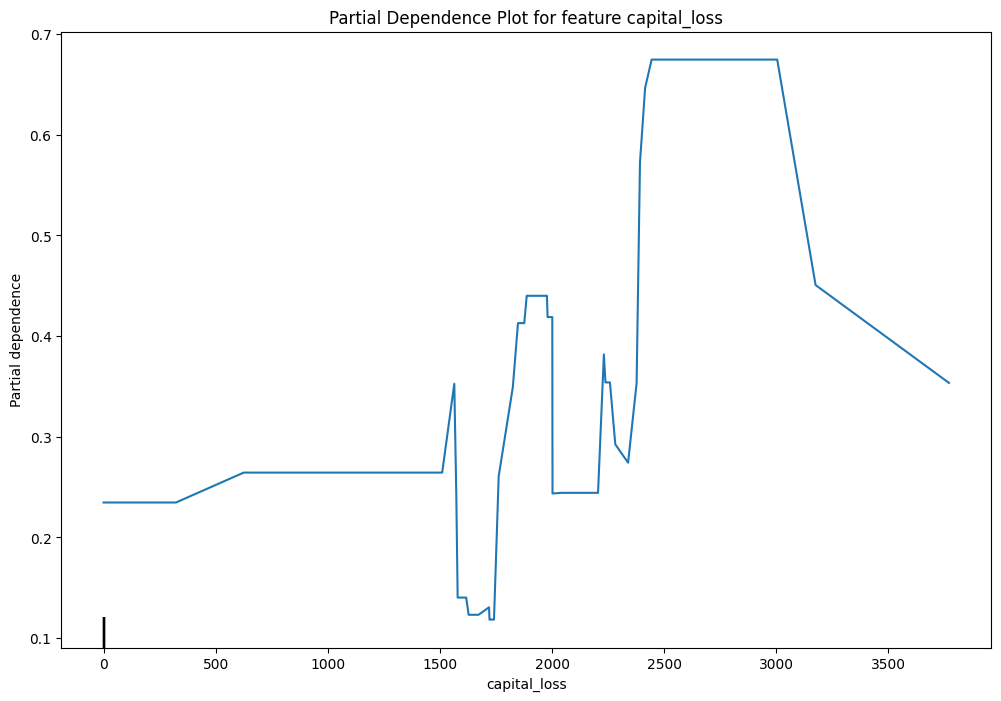

4


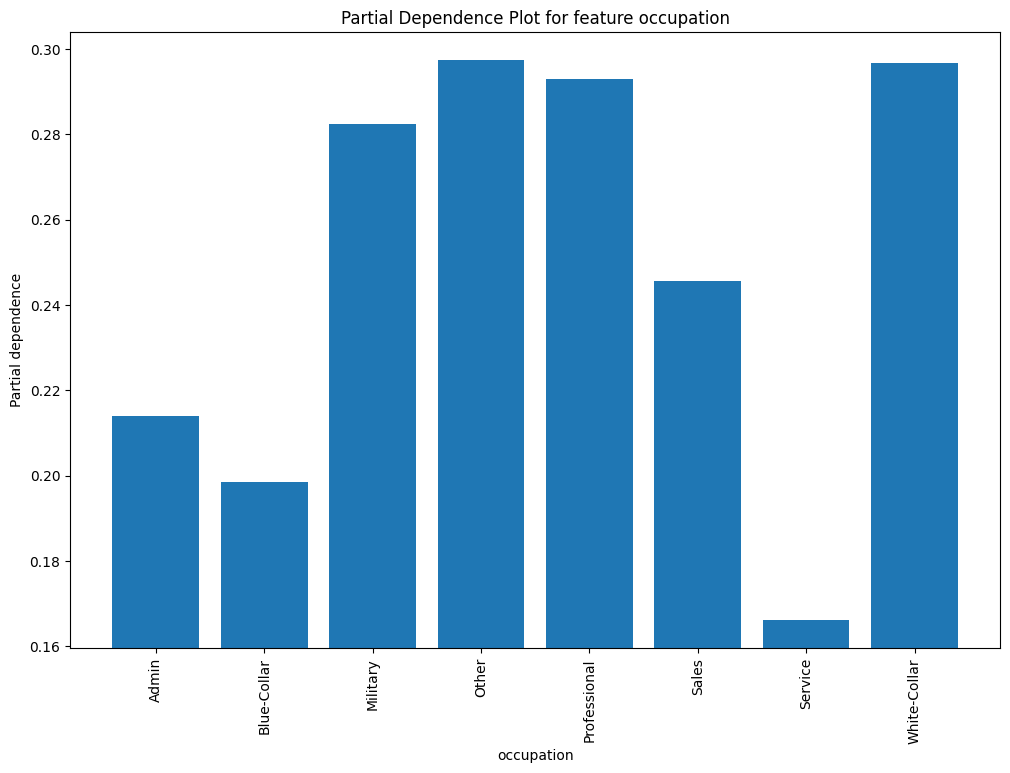

2


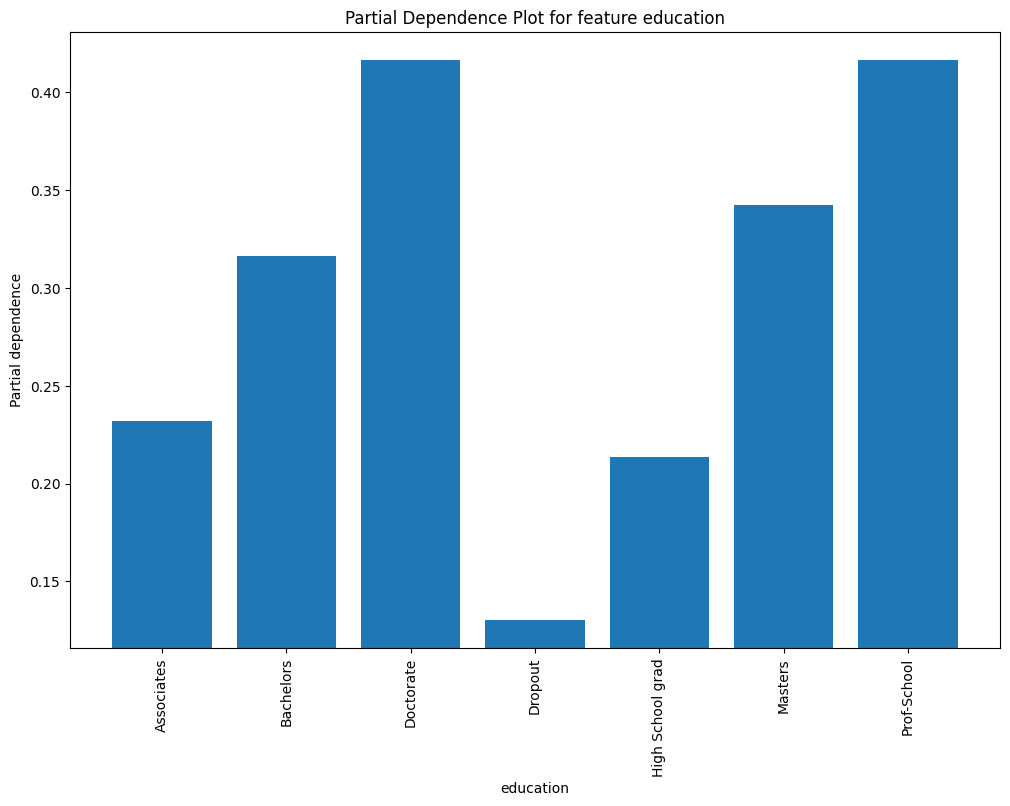

0


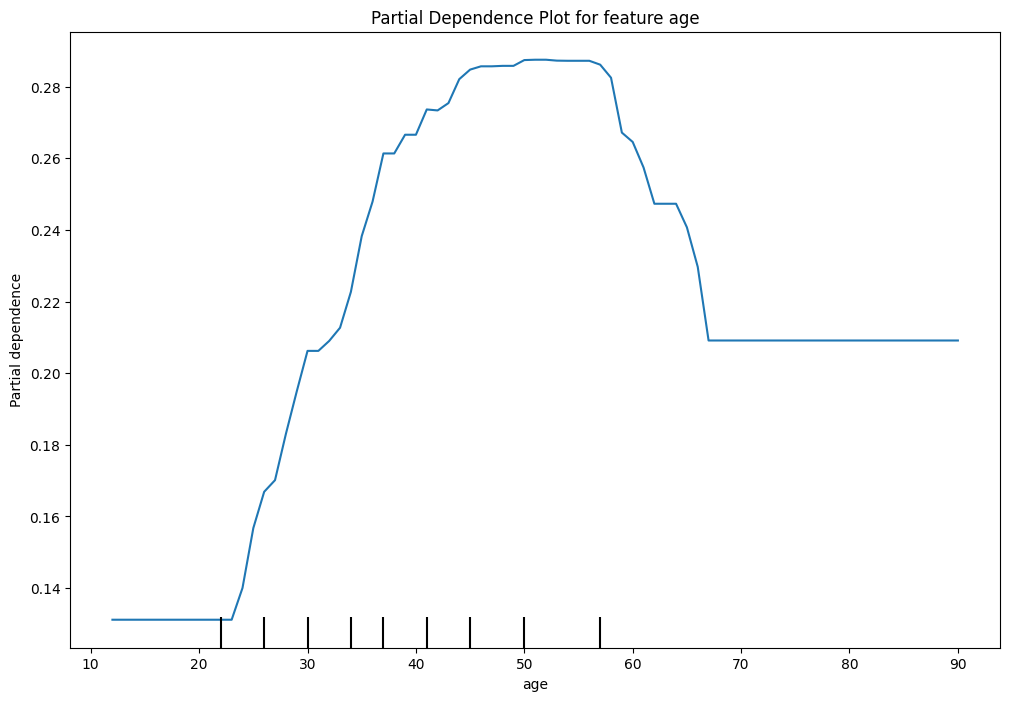

8


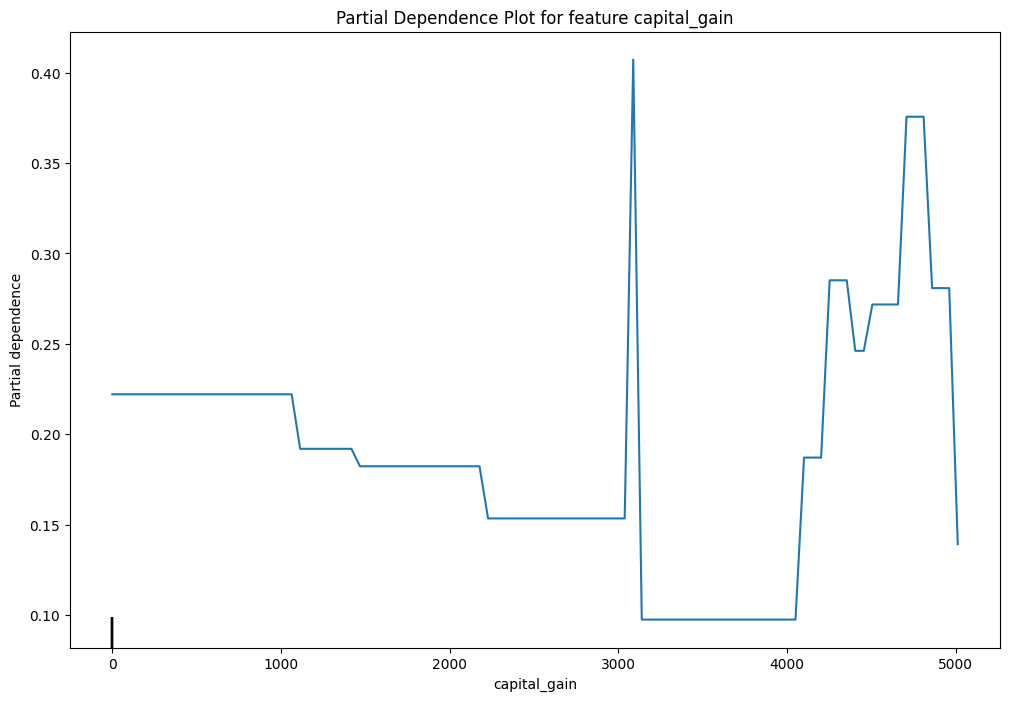

3


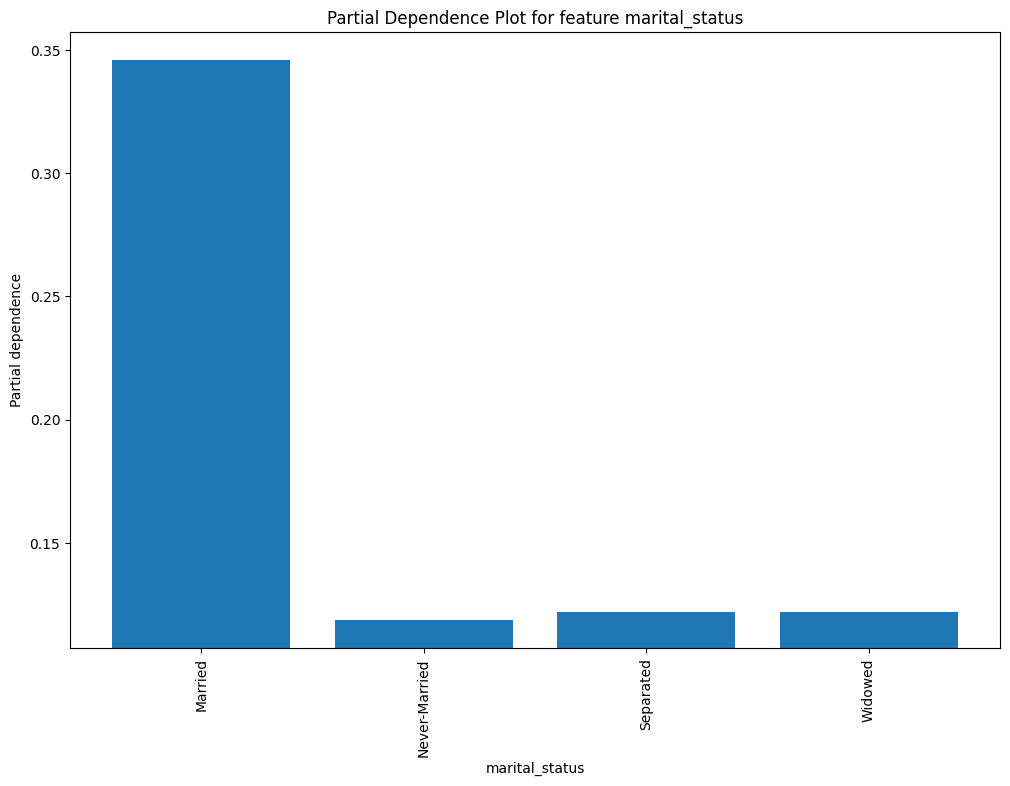

In [24]:
## Partial dependence plots
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
feature_importances = clf.feature_importances_
important_features = np.argsort(feature_importances)[-6:]

# Plot Partial Dependence Plots for each feature
for feature in important_features:
    print(feature)
    fig, ax = plt.subplots(figsize=(12, 8))
    display = PartialDependenceDisplay.from_estimator(
        clf, 
        Xtest.drop(['income'],axis=1), 
        features=[feature], 
        ax=ax, 
        categorical_features=cat_feat,
        feature_names=feature_names
    )
    ff =feature_names[feature]
    plt.title(f'Partial Dependence Plot for feature {ff}')
    plt.show()

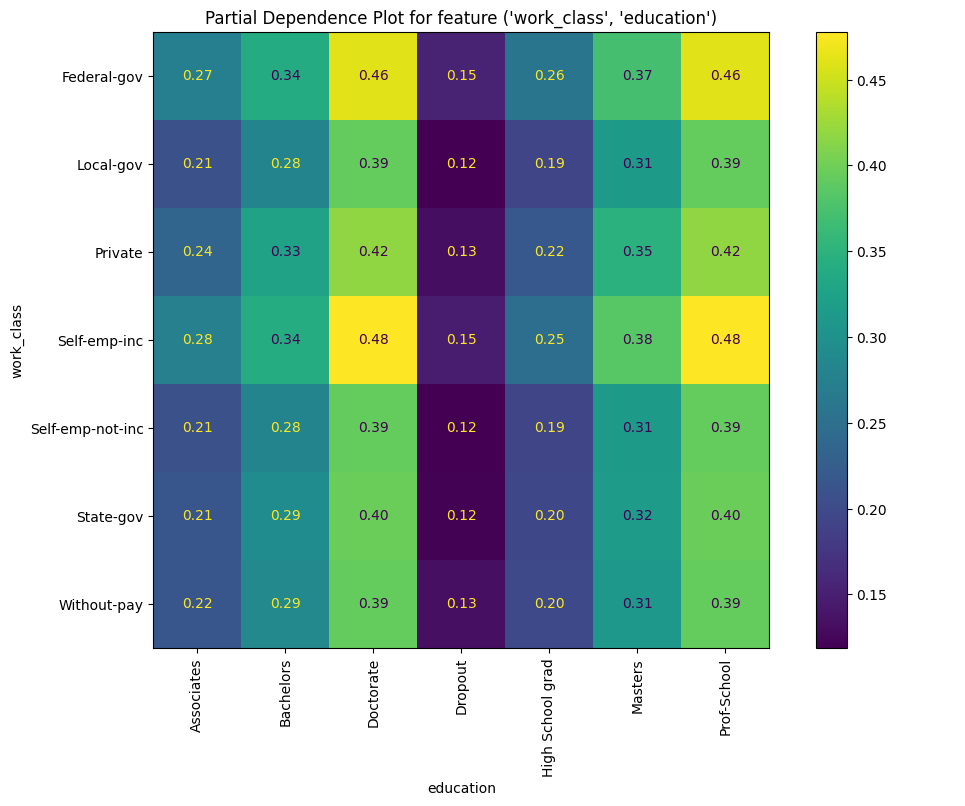

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(
                                                    clf, 
                                                    Xtest.drop(['income'],axis=1), 
                                                    features=[(1,2)], 
                                                    ax=ax, 
                                                    categorical_features=cat_feat,
                                                    feature_names=feature_names
                                                )
plt.title(f'Partial Dependence Plot for feature {feature_names[1],feature_names[2]}')
plt.show()